## 1. Setup and Imports

Import all required libraries for data collection, preprocessing, modeling, and visualization.


In [2]:
import os
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    silhouette_score, davies_bouldin_score, calinski_harabasz_score
)
import xgboost as xgb


sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print(" All libraries imported successfully!")


 All libraries imported successfully!


## 2. Configuration

Set up constants for cache directory, race list, and export settings.


In [3]:
# Configuration
CACHE_DIR = "cache"  # for FastF1

RACES = [
    (2023, "Bahrain"),
    (2023, "Saudi Arabia"),
    (2023, "Australia"),
    (2023, "Azerbaijan"),
    (2023, "Spain"),
    (2023, "Canada"),
    (2023, "Austria"),
    (2023, "Belgium"),
]

SAVE_CSV = True  

print(f"Configured to analyze {len(RACES)} races from 2023 season")


Configured to analyze 8 races from 2023 season


## 3. Data Collection

Download F1 race data from FastF1 API. Data is automatically cached for faster subsequent runs.


In [4]:
def load_raw_laps():
  
  
    csv_path = "raw_laps.csv"
    if SAVE_CSV and os.path.exists(csv_path):
        print(f"Loading data from cached CSV file: {csv_path}")
        df_all = pd.read_csv(csv_path)
        # Convert any datetime columns back to datetime if needed
        if 'LapTime' in df_all.columns:
            df_all['LapTime'] = pd.to_timedelta(df_all['LapTime'])
        # Check if temperature columns exist, if not regenerate
        if 'AirTemp' not in df_all.columns or 'TrackTemp' not in df_all.columns:
            print("  Temperature columns missing in cache, regenerating with weather data...")
            os.remove(csv_path)  # Delete old CSV to force regeneration
        else:
            print(f"Loaded {df_all.shape[0]} rows, {df_all.shape[1]} columns from cache")
            return df_all
    
    # Create cache directory if it doesn't exist
    os.makedirs(CACHE_DIR, exist_ok=True)
    
    # Enable FastF1 cache (automatically uses cached data if available)
    fastf1.Cache.enable_cache(CACHE_DIR)
    
    all_laps = []
    
    print("Downloading race data from FastF1 (this may take a few minutes)...")
    print("Note: Data will be cached for faster future runs.")
    for year, race_name in RACES:
        print(f"  Loading {year} {race_name}...")
        try:
            # Get race session
            session = fastf1.get_session(year, race_name, "R")
            session.load()  # FastF1 automatically uses cache if available
            
            # Copy laps DataFrame and add race identifier
            df = session.laps.copy()
            df['race'] = f"{year} {race_name}"
            
            # Merge weather data with laps based on time
            weather = session.weather_data.copy()
            if not weather.empty and 'Time' in df.columns and 'Time' in weather.columns:
                # Sort both dataframes by time for merge_asof
                df = df.sort_values('Time').reset_index(drop=True)
                weather = weather.sort_values('Time').reset_index(drop=True)
                # Select only temperature columns from weather
                weather_temp = weather[['Time', 'AirTemp', 'TrackTemp']].copy()
                # Merge asof to get closest weather reading for each lap
                df = pd.merge_asof(df, weather_temp, on='Time', direction='backward')
            
            all_laps.append(df)
            print(f"    Loaded {len(df)} laps")
        except Exception as e:
            print(f"    Error loading {year} {race_name}: {e}")
            continue
    
    # Concatenate all laps
    if all_laps:
        df_all = pd.concat(all_laps, ignore_index=True)
        print(f"\nTotal laps loaded: {df_all.shape[0]} rows, {df_all.shape[1]} columns")
        
        # Optionally save raw data for even faster loading next time
        if SAVE_CSV:
            df_all.to_csv(csv_path, index=False)
            print(f"Saved {csv_path} for faster loading next time")
        
        return df_all
    else:
        print("No data loaded!")
        return pd.DataFrame()

# Load the data
df_raw = load_raw_laps()
print(f"\n Data loaded: {df_raw.shape[0]} laps, {df_raw.shape[1]} columns")


Loading data from cached CSV file: raw_laps.csv
Loaded 8763 rows, 34 columns from cache

 Data loaded: 8763 laps, 34 columns


In [5]:
# 4.1 Lap-Time Dataset
def make_laptime_dataset(df_raw):
    #Creates lap-time dataset for regression model.
    # Check for required columns
    required_cols = ['LapTime', 'Compound', 'AirTemp', 'TrackTemp', 'Driver', 'race']
    missing_cols = [col for col in required_cols if col not in df_raw.columns]
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}")
        raise KeyError(f"Missing columns: {missing_cols}")
    
    # Select relevant columns
    df_lap = df_raw[required_cols].copy()
    
    # Drop rows with missing values
    df_lap = df_lap.dropna(subset=['LapTime', 'Compound', 'AirTemp', 'TrackTemp', 'Driver'])
    
    # Convert LapTime from timedelta to float seconds
    df_lap['LapTimeSeconds'] = df_lap['LapTime'].dt.total_seconds()
    
    # Drop the original LapTime column
    df_lap = df_lap.drop('LapTime', axis=1)
    
    print(f"Lap-time dataset: {df_lap.shape[0]} rows")
    
    if SAVE_CSV:
        df_lap.to_csv("laptime_dataset.csv", index=False)
        print("Saved laptime_dataset.csv")
    
    return df_lap

df_lap = make_laptime_dataset(df_raw)
df_lap.head()


Lap-time dataset: 8568 rows
Saved laptime_dataset.csv


,Compound,AirTemp,TrackTemp,Driver,race,LapTimeSeconds
0,SOFT,27.3,31.2,VER,2023 Bahrain,99.019
1,SOFT,27.3,31.2,LEC,2023 Bahrain,100.230
2,SOFT,27.3,31.2,PER,2023 Bahrain,101.063
3,SOFT,27.3,31.2,SAI,2023 Bahrain,101.659
4,SOFT,27.3,31.2,HAM,2023 Bahrain,102.288


In [6]:
# 4.2 Pit-Stop Dataset
def make_pit_dataset(df_raw):
    #Creates pit-stop dataset for classification model.
    # Select relevant columns
    df_pit = df_raw[['LapNumber', 'TyreLife', 'Compound', 'Driver', 'race']].copy()
    
    # Drop NA
    df_pit = df_pit.dropna(subset=['LapNumber', 'TyreLife', 'Compound', 'Driver'])
    
    # Create label column: should_pit
    # Pit stop likely needed if: high lap number OR high tyre life
    df_pit['should_pit'] = ((df_pit['LapNumber'] > 25) | (df_pit['TyreLife'] > 18)).astype(int)
    
    print(f"Pit-stop dataset: {df_pit.shape[0]} rows")
    
    if SAVE_CSV:
        df_pit.to_csv("pit_dataset.csv", index=False)
        print("Saved pit_dataset.csv")
    
    return df_pit

df_pit = make_pit_dataset(df_raw)
df_pit.head()


Pit-stop dataset: 8728 rows
Saved pit_dataset.csv


,LapNumber,TyreLife,Compound,Driver,race,should_pit
0,1.0,4.0,SOFT,VER,2023 Bahrain,0
1,1.0,1.0,SOFT,LEC,2023 Bahrain,0
2,1.0,4.0,SOFT,PER,2023 Bahrain,0
3,1.0,4.0,SOFT,SAI,2023 Bahrain,0
4,1.0,4.0,SOFT,HAM,2023 Bahrain,0


In [7]:
# 4.3 Driver Stats Dataset
def make_driver_stats(df_raw):
    #Creates driver statistics dataset for clustering.
    # Select relevant columns
    df_driver = df_raw[['Driver', 'LapTime']].copy()
    
    # Drop NA
    df_driver = df_driver.dropna(subset=['Driver', 'LapTime'])
    
    # Convert LapTime to seconds
    df_driver['LapTimeSeconds'] = df_driver['LapTime'].dt.total_seconds()
    
    # Drop the original LapTime column
    df_driver = df_driver.drop('LapTime', axis=1)
    
    # Group by Driver and compute statistics
    df_driver = df_driver.groupby('Driver').agg({
        'LapTimeSeconds': ['mean', 'std', 'count']
    }).reset_index()
    
    # Flatten column names
    df_driver.columns = ['Driver', 'avg_lap', 'std_lap', 'lap_count']
    
    # Drop rows with NaN std (drivers with only 1 lap)
    df_driver = df_driver.dropna(subset=['std_lap'])
    
    print(f"Driver stats dataset: {df_driver.shape[0]} drivers")
    
    if SAVE_CSV:
        df_driver.to_csv("driver_stats.csv", index=False)
        print("Saved driver_stats.csv")
    
    return df_driver

df_driver = make_driver_stats(df_raw)
df_driver.head()


Driver stats dataset: 21 drivers
Saved driver_stats.csv


,Driver,avg_lap,std_lap,lap_count
0,ALB,91.963586,17.288813,389
1,ALO,89.945540,15.380255,457
2,BOT,91.663936,15.777062,454
3,DEV,87.229965,13.740798,370
4,GAS,91.085635,16.100660,460


## 5. Model 1: Lap-Time Prediction (Regression)

Predict lap times based on tire compound and temperature conditions.

**Models:** Linear Regression, Random Forest, XGBoost  
**Metrics:** RMSE, MAE, R²


In [8]:
# Prepare features and target
y = df_lap['LapTimeSeconds']
X = df_lap[['Compound', 'AirTemp', 'TrackTemp']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Preprocessing: OneHotEncoder for Compound, StandardScaler for temps
preprocessor = ColumnTransformer(
    transformers=[
        ('compound', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['Compound']),
        ('temps', StandardScaler(), ['AirTemp', 'TrackTemp'])
    ],
    remainder='passthrough'
)


Training set: 6854 samples
Test set: 1714 samples


In [11]:
# Model 1: Linear Regression (Baseline)
print("="*60)
print("LAP-TIME PREDICTION MODEL (Regression)")
print("="*60)
print("\n Linear Regression")

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"RMSE: {rmse_lr:.3f} seconds")
print(f"MAE:  {mae_lr:.3f} seconds")
print(f"R²:   {r2_lr:.4f}")


LAP-TIME PREDICTION MODEL (Regression)

 Linear Regression
RMSE: 14.925 seconds
MAE:  11.690 seconds
R²:   0.1287


In [12]:
# Model 2: Random Forest Regressor
print("\n--- Random Forest Regressor ---")

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rmse_rf:.3f} seconds")
print(f"MAE:  {mae_rf:.3f} seconds")
print(f"R²:   {r2_rf:.4f}")



--- Random Forest Regressor ---
RMSE: 4.573 seconds
MAE:  2.011 seconds
R²:   0.9182


In [13]:
# Model 3: XGBoost Regressor
print("\n--- XGBoost Regressor ---")

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0))
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"RMSE: {rmse_xgb:.3f} seconds")
print(f"MAE:  {mae_xgb:.3f} seconds")
print(f"R²:   {r2_xgb:.4f}")



--- XGBoost Regressor ---
RMSE: 4.489 seconds
MAE:  1.995 seconds
R²:   0.9212


In [14]:
# Model Comparison
print("\n--- Model Comparison ---")
print(f"{'Model':<25} {'RMSE':<12} {'MAE':<12} {'R²':<10}")
print("-" * 60)
print(f"{'Linear Regression':<25} {rmse_lr:<12.3f} {mae_lr:<12.3f} {r2_lr:<10.4f}")
print(f"{'Random Forest':<25} {rmse_rf:<12.3f} {mae_rf:<12.3f} {r2_rf:<10.4f}")
print(f"{'XGBoost':<25} {rmse_xgb:<12.3f} {mae_xgb:<12.3f} {r2_xgb:<10.4f}")



--- Model Comparison ---
Model                     RMSE         MAE          R²        
------------------------------------------------------------
Linear Regression         14.925       11.690       0.1287    
Random Forest             4.573        2.011        0.9182    
XGBoost                   4.489        1.995        0.9212    


## 6. Model 2: Pit-Stop Prediction (Classification)

Classify whether a driver should make a pit stop on a given lap.

**Models:** Logistic Regression, Random Forest, Gradient Boosting  
**Metrics:** Accuracy, Precision, Recall, F1, AUC-ROC


In [15]:
# Prepare features and target
y = df_pit['should_pit']
X = df_pit[['Compound', 'TyreLife', 'LapNumber']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*60)
print("PIT-STOP PREDICTION MODEL (Classification)")
print("="*60)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Pit stop rate in test set: {y_test.mean():.2%}")

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('compound', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['Compound']),
        ('numeric', StandardScaler(), ['TyreLife', 'LapNumber'])
    ],
    remainder='passthrough'
)


PIT-STOP PREDICTION MODEL (Classification)

Training set: 6982 samples
Test set: 1746 samples
Pit stop rate in test set: 57.67%


In [16]:
# Model 1: Logistic Regression
print("\n--- Logistic Regression ---")

pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, zero_division=0)
rec_lr = recall_score(y_test, y_pred_lr, zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, zero_division=0)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy:  {acc_lr:.3f}")
print(f"Precision: {prec_lr:.3f}")
print(f"Recall:    {rec_lr:.3f}")
print(f"F1 Score:  {f1_lr:.3f}")
print(f"AUC-ROC:   {auc_lr:.4f}")



--- Logistic Regression ---
Accuracy:  0.978
Precision: 0.985
Recall:    0.977
F1 Score:  0.981
AUC-ROC:   0.9983


In [17]:
# Model 2: Random Forest Classifier
print("\n--- Random Forest Classifier ---")

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, zero_division=0)
rec_rf = recall_score(y_test, y_pred_rf, zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=0)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy:  {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall:    {rec_rf:.3f}")
print(f"F1 Score:  {f1_rf:.3f}")
print(f"AUC-ROC:   {auc_rf:.4f}")



--- Random Forest Classifier ---
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000
AUC-ROC:   1.0000


In [18]:
# Model 3: Gradient Boosting Classifier
print("\n--- Gradient Boosting Classifier ---")

pipeline_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_test)
y_pred_proba_gb = pipeline_gb.predict_proba(X_test)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, zero_division=0)
rec_gb = recall_score(y_test, y_pred_gb, zero_division=0)
f1_gb = f1_score(y_test, y_pred_gb, zero_division=0)
auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Accuracy:  {acc_gb:.3f}")
print(f"Precision: {prec_gb:.3f}")
print(f"Recall:    {rec_gb:.3f}")
print(f"F1 Score:  {f1_gb:.3f}")
print(f"AUC-ROC:   {auc_gb:.4f}")



--- Gradient Boosting Classifier ---
Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000
AUC-ROC:   1.0000


In [19]:
# Model Comparison
print("\n--- Model Comparison ---")
print(f"{'Model':<30} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'AUC-ROC':<10}")
print("-" * 80)
print(f"{'Logistic Regression':<30} {acc_lr:<10.3f} {prec_lr:<10.3f} {rec_lr:<10.3f} {f1_lr:<10.3f} {auc_lr:<10.4f}")
print(f"{'Random Forest':<30} {acc_rf:<10.3f} {prec_rf:<10.3f} {rec_rf:<10.3f} {f1_rf:<10.3f} {auc_rf:<10.4f}")
print(f"{'Gradient Boosting':<30} {acc_gb:<10.3f} {prec_gb:<10.3f} {rec_gb:<10.3f} {f1_gb:<10.3f} {auc_gb:<10.4f}")



--- Model Comparison ---
Model                          Accuracy   Precision  Recall     F1         AUC-ROC   
--------------------------------------------------------------------------------
Logistic Regression            0.978      0.985      0.977      0.981      0.9983    
Random Forest                  1.000      1.000      1.000      1.000      1.0000    
Gradient Boosting              1.000      1.000      1.000      1.000      1.0000    


## 7. Model 3: Driver Clustering (Unsupervised Learning)

Group drivers into performance clusters using K-Means, Hierarchical, and DBSCAN algorithms.

**Metrics:** Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index


In [ ]:
# Prepare features
features = ['avg_lap', 'std_lap', 'lap_count']
X = df_driver[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_clusters = 3
results = {}

print("="*60)
print("DRIVER CLUSTERING (Unsupervised Learning")
print("="*60)


DRIVER CLUSTERING (Multiple Algorithms)


In [21]:
# Algorithm 1: K-Means
print("\n--- K-Means Clustering ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_scaled)
df_driver['cluster_kmeans'] = labels_kmeans

sil_kmeans = silhouette_score(X_scaled, labels_kmeans)
db_kmeans = davies_bouldin_score(X_scaled, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X_scaled, labels_kmeans)

print(f"Number of clusters: {n_clusters}")
print(f"Silhouette Score: {sil_kmeans:.4f} (higher is better, range: -1 to 1)")
print(f"Davies-Bouldin Index: {db_kmeans:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {ch_kmeans:.4f} (higher is better)")

results['KMeans'] = {
    'labels': labels_kmeans,
    'silhouette': sil_kmeans,
    'davies_bouldin': db_kmeans,
    'calinski_harabasz': ch_kmeans
}



--- K-Means Clustering ---
Number of clusters: 3
Silhouette Score: 0.4068 (higher is better, range: -1 to 1)
Davies-Bouldin Index: 0.7781 (lower is better)
Calinski-Harabasz Index: 144.5580 (higher is better)


In [22]:
# Algorithm 2: Hierarchical Clustering
print("\n--- Hierarchical Clustering (Agglomerative) ---")
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_hier = hierarchical.fit_predict(X_scaled)
df_driver['cluster_hierarchical'] = labels_hier

sil_hier = silhouette_score(X_scaled, labels_hier)
db_hier = davies_bouldin_score(X_scaled, labels_hier)
ch_hier = calinski_harabasz_score(X_scaled, labels_hier)

print(f"Number of clusters: {n_clusters}")
print(f"Silhouette Score: {sil_hier:.4f} (higher is better, range: -1 to 1)")
print(f"Davies-Bouldin Index: {db_hier:.4f} (lower is better)")
print(f"Calinski-Harabasz Index: {ch_hier:.4f} (higher is better)")

results['Hierarchical'] = {
    'labels': labels_hier,
    'silhouette': sil_hier,
    'davies_bouldin': db_hier,
    'calinski_harabasz': ch_hier
}



--- Hierarchical Clustering (Agglomerative) ---
Number of clusters: 3
Silhouette Score: 0.4068 (higher is better, range: -1 to 1)
Davies-Bouldin Index: 0.7781 (lower is better)
Calinski-Harabasz Index: 144.5580 (higher is better)


In [23]:
# Algorithm 3: DBSCAN
print("\n--- DBSCAN Clustering ---")
dbscan = DBSCAN(eps=1.0, min_samples=3)
labels_dbscan = dbscan.fit_predict(X_scaled)
df_driver['cluster_dbscan'] = labels_dbscan

# DBSCAN may create noise points (-1)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"Number of clusters found: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

# Only compute metrics if we have at least 2 clusters
if n_clusters_dbscan >= 2 and n_noise < len(labels_dbscan):
    sil_dbscan = silhouette_score(X_scaled, labels_dbscan)
    db_dbscan = davies_bouldin_score(X_scaled, labels_dbscan)
    ch_dbscan = calinski_harabasz_score(X_scaled, labels_dbscan)
    
    print(f"Silhouette Score: {sil_dbscan:.4f} (higher is better, range: -1 to 1)")
    print(f"Davies-Bouldin Index: {db_dbscan:.4f} (lower is better)")
    print(f"Calinski-Harabasz Index: {ch_dbscan:.4f} (higher is better)")
    
    results['DBSCAN'] = {
        'labels': labels_dbscan,
        'silhouette': sil_dbscan,
        'davies_bouldin': db_dbscan,
        'calinski_harabasz': ch_dbscan,
        'n_clusters': n_clusters_dbscan,
        'n_noise': n_noise
    }
else:
    print("Warning: DBSCAN found too many noise points or too few clusters for meaningful evaluation")
    results['DBSCAN'] = {
        'labels': labels_dbscan,
        'silhouette': None,
        'davies_bouldin': None,
        'calinski_harabasz': None,
        'n_clusters': n_clusters_dbscan,
        'n_noise': n_noise
    }



--- DBSCAN Clustering ---
Number of clusters found: 1
Number of noise points: 1


In [27]:
# Model Comparison
print("\n--- Clustering Algorithm Comparison ---")
print(f"{'Algorithm':<20} {'Silhouette':<12} {'Davies-Bouldin':<15} {'Calinski-Harabasz':<18}")
print("-" * 70)
for algo_name, metrics in results.items():
    if metrics['silhouette'] is not None:
        print(f"{algo_name:<20} {metrics['silhouette']:<12.4f} {metrics['davies_bouldin']:<15.4f} {metrics['calinski_harabasz']:<18.4f}")
    else:
        print(f"{algo_name:<20} {'N/A':<12} {'N/A':<15} {'N/A':<18}")

# Use KMeans as default for main cluster column
df_driver['cluster'] = labels_kmeans

# Print cluster summary
print("\n--- K-Means Cluster Summary ---")
cluster_summary = df_driver.groupby('cluster_kmeans').agg({
    'avg_lap': 'mean',
    'std_lap': 'mean',
    'lap_count': 'mean',
    'Driver': 'count'
}).round(3)
cluster_summary.columns = ['Avg Lap Time', 'Avg Std', 'Avg Lap Count', 'Driver Count']
print(cluster_summary)

# Print full table with drivers
print("\n--- Driver Clusters (K-Means) ---")
df_display = df_driver[['Driver', 'avg_lap', 'std_lap', 'cluster_kmeans', 
                        'cluster_hierarchical', 'cluster_dbscan']].sort_values('avg_lap')
df_display.columns = ['Driver', 'avg_lap', 'std_lap', 'KMeans', 'Hierarchical', 'DBSCAN']
print(df_display.to_string(index=False))

if SAVE_CSV:
    df_driver.to_csv("driver_clusters.csv", index=False)
    print("\nSaved driver_clusters.csv with all clustering results")



--- Clustering Algorithm Comparison ---
Algorithm            Silhouette   Davies-Bouldin  Calinski-Harabasz 
----------------------------------------------------------------------
KMeans               0.4068       0.7781          144.5580          
Hierarchical         0.4068       0.7781          144.5580          
DBSCAN               N/A          N/A             N/A               

--- K-Means Cluster Summary ---
                Avg Lap Time  Avg Std  Avg Lap Count  Driver Count
cluster_kmeans                                                    
0                     90.881   15.579        386.571             7
1                    114.853    4.179         44.000             1
2                     90.605   15.788        450.231            13

--- Driver Clusters (K-Means) ---
Driver    avg_lap   std_lap  KMeans  Hierarchical  DBSCAN
   DEV  87.229965 13.740798       0             0       0
   PIA  87.852022 15.207581       0             0       0
   SAI  89.169472 15.264225       2

## 8. Visualizations

Create comprehensive charts to visualize the results.


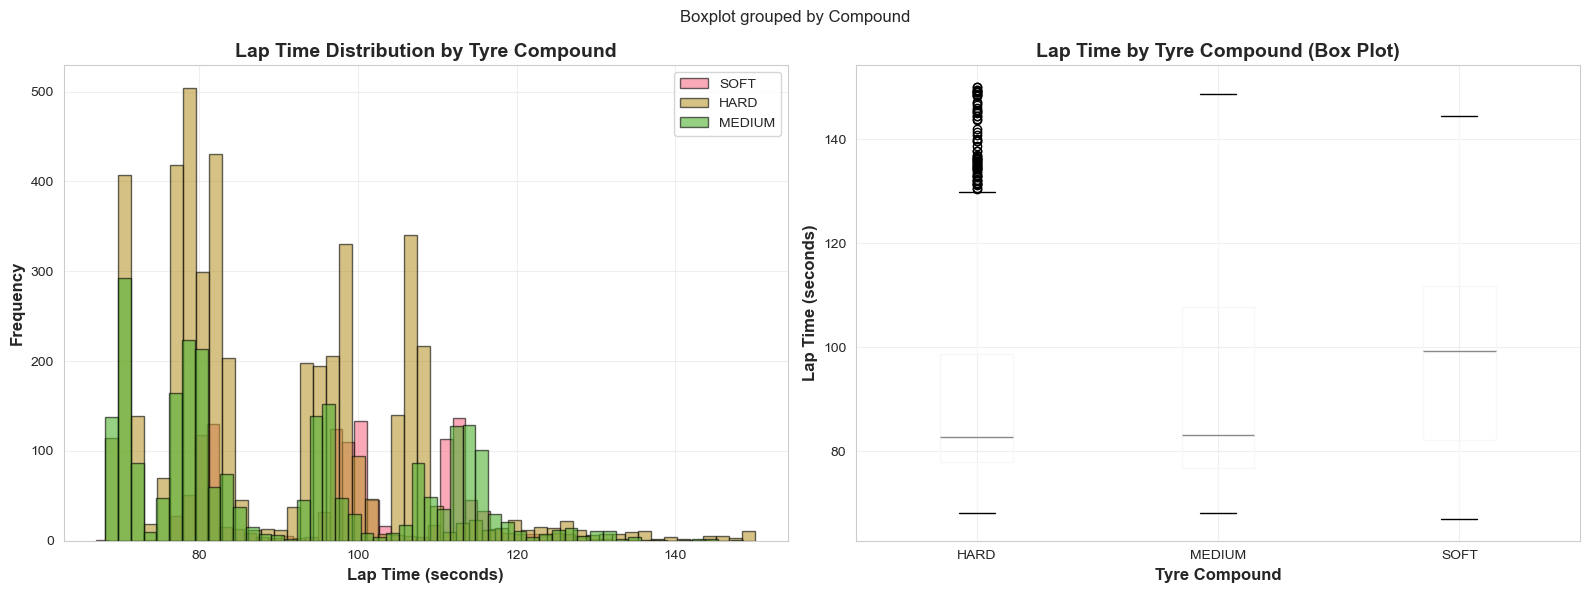

In [24]:
# Chart 1: Lap Time Distribution by Compound
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribution plot
compounds = df_lap['Compound'].unique()
for compound in compounds:
    data = df_lap[df_lap['Compound'] == compound]['LapTimeSeconds']
    axes[0].hist(data, bins=50, alpha=0.6, label=compound, edgecolor='black')

axes[0].set_xlabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Lap Time Distribution by Tyre Compound', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
df_lap.boxplot(column='LapTimeSeconds', by='Compound', ax=axes[1])
axes[1].set_xlabel('Tyre Compound', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_title('Lap Time by Tyre Compound (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


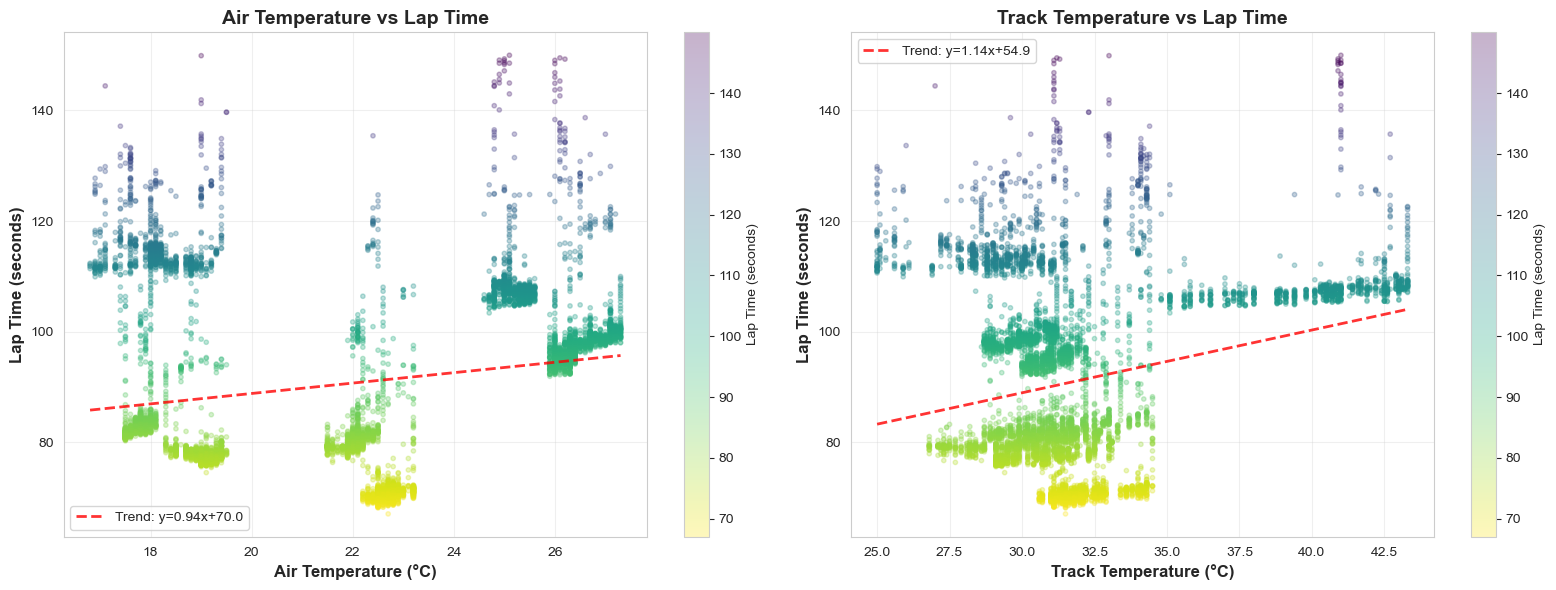

In [25]:
# Chart 2: Temperature Effects on Lap Times
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Air temperature vs lap time
scatter1 = axes[0].scatter(df_lap['AirTemp'], df_lap['LapTimeSeconds'], 
                          alpha=0.3, s=10, c=df_lap['LapTimeSeconds'], 
                          cmap='viridis_r')
z1 = np.polyfit(df_lap['AirTemp'], df_lap['LapTimeSeconds'], 1)
p1 = np.poly1d(z1)
axes[0].plot(df_lap['AirTemp'].sort_values(), 
             p1(df_lap['AirTemp'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z1[0]:.2f}x+{z1[1]:.1f}')
axes[0].set_xlabel('Air Temperature (°C)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_title('Air Temperature vs Lap Time', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Lap Time (seconds)')

# Track temperature vs lap time
scatter2 = axes[1].scatter(df_lap['TrackTemp'], df_lap['LapTimeSeconds'], 
                          alpha=0.3, s=10, c=df_lap['LapTimeSeconds'], 
                          cmap='viridis_r')
z2 = np.polyfit(df_lap['TrackTemp'], df_lap['LapTimeSeconds'], 1)
p2 = np.poly1d(z2)
axes[1].plot(df_lap['TrackTemp'].sort_values(), 
             p2(df_lap['TrackTemp'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z2[0]:.2f}x+{z2[1]:.1f}')
axes[1].set_xlabel('Track Temperature (°C)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_title('Track Temperature vs Lap Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Lap Time (seconds)')

plt.tight_layout()
plt.show()


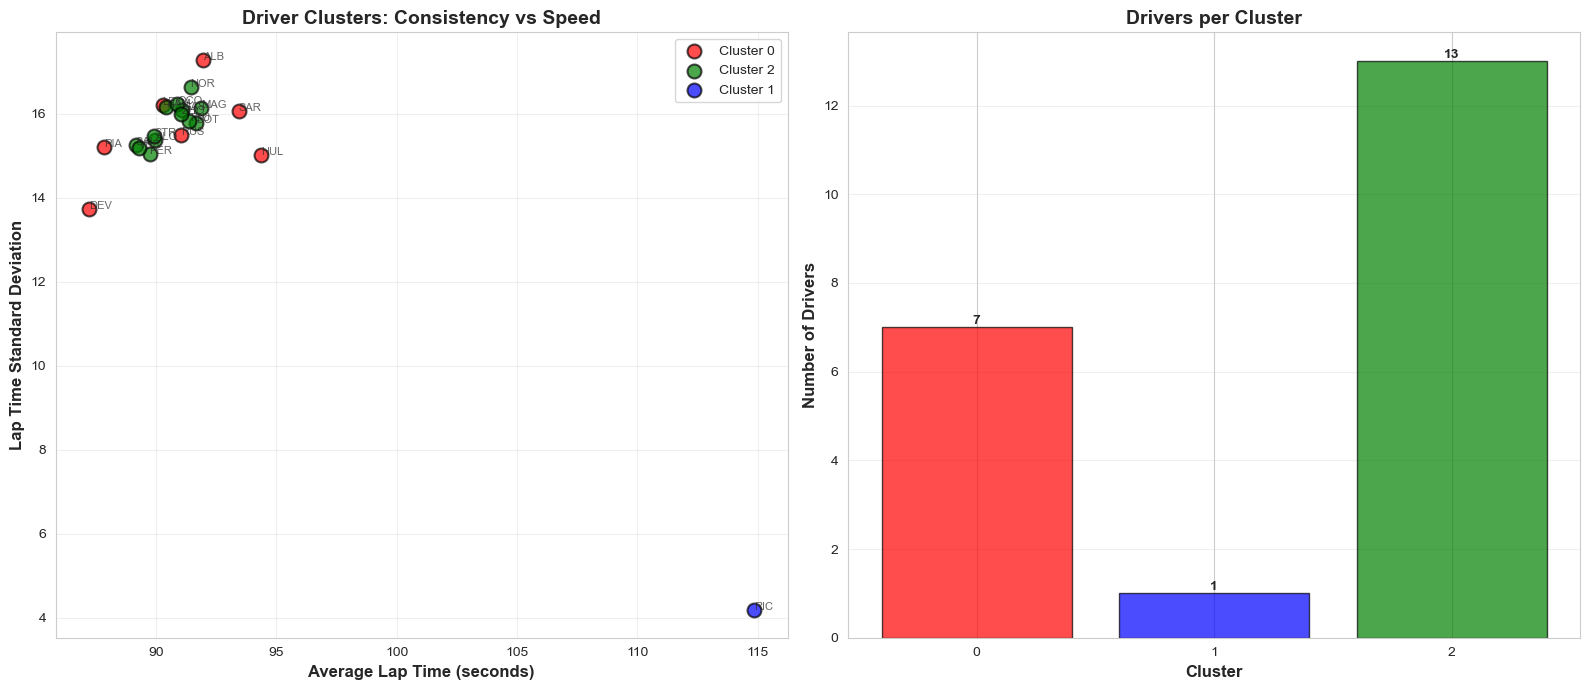

In [26]:
# Chart 3: Driver Clustering Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Scatter plot: avg_lap vs std_lap colored by cluster
clusters = df_driver['cluster_kmeans'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple']

for cluster in clusters:
    cluster_data = df_driver[df_driver['cluster_kmeans'] == cluster]
    axes[0].scatter(cluster_data['avg_lap'], cluster_data['std_lap'], 
                   label=f'Cluster {cluster}', s=100, alpha=0.7, 
                   edgecolor='black', linewidth=1.5, c=colors[int(cluster)])

# Add driver labels
for _, row in df_driver.iterrows():
    axes[0].annotate(row['Driver'], 
                    (row['avg_lap'], row['std_lap']), 
                    fontsize=8, alpha=0.7)

axes[0].set_xlabel('Average Lap Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Lap Time Standard Deviation', fontsize=12, fontweight='bold')
axes[0].set_title('Driver Clusters: Consistency vs Speed', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart: drivers by cluster
cluster_counts = df_driver.groupby('cluster_kmeans').size().reset_index()
cluster_counts.columns = ['cluster', 'count']

bars = axes[1].bar(cluster_counts['cluster'], cluster_counts['count'], 
                   alpha=0.7, edgecolor='black', 
                   color=[colors[int(c)] for c in cluster_counts['cluster']])
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Drivers', fontsize=12, fontweight='bold')
axes[1].set_title('Drivers per Cluster', fontsize=14, fontweight='bold')
axes[1].set_xticks(cluster_counts['cluster'])
axes[1].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
